# Automatic cell type annotation with GPT/Other

GPTCelltype, an open-source R software package to facilitate cell type annotation by GPT-4. 

We made three improvements in integrating the `GPTCelltype` algorithm in OmicVerse:

- **Native support for Python**: Since GPTCelltype is an R language package, in order to make it conform to scverse's anndata ecosystem, we have rewritten the whole function so that it works perfectly under Python.
- **More model support**: We provide more big models to choose from outside of Openai, e.g. Qwen(通义千问), Kimi, and more model support is available through the parameter `base_url`.

If you found this tutorial helpful, please cite GPTCelltype and OmicVerse:

Hou, W. and Ji, Z., 2023. Reference-free and cost-effective automated cell type annotation with GPT-4 in single-cell RNA-seq analysis. [Nature Methods, 2024 March 25](https://link.springer.com/article/10.1038/s41592-024-02235-4?utm_source=rct_congratemailt&utm_medium=email&utm_campaign=oa_20240325&utm_content=10.1038/s41592-024-02235-4).

In [2]:
import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.0, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.6.0
scanpy version:1.7.2


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [21]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation. 

But if you want to experience step-by-step preprocessing, we also provide more detailed preprocessing steps here, please refer to our [preprocess chapter](https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_preprocess/) for a detailed explanation.

We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [ ]:
#adata=ov.single.scanpy_lazy(adata)

#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

#Neighbourhood graph construction
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
sc.tl.leiden(adata)

#find marker
sc.tl.dendrogram(adata,'leiden',use_rep='scaled|original|X_pca')
sc.tl.rank_genes_groups(adata, 'leiden', use_rep='scaled|original|X_pca',
                        method='wilcoxon',use_raw=False,)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

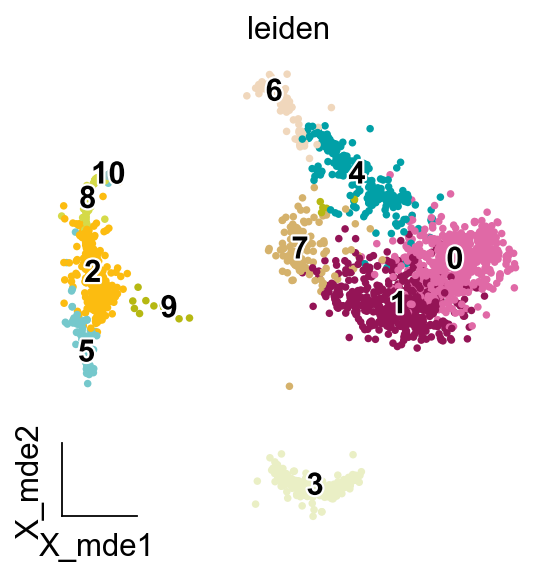

In [5]:
ov.pl.embedding(adata,
                   basis='X_mde',
                   color=['leiden'], 
                   legend_loc='on data', 
                   frameon='small',
                   legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

## GPT Celltype

gptcelltype supports dictionary format input, we provide `omicverse.single.get_celltype_marker` to get the marker genes for each cell type as a dictionary.

### Using genes manual

We can manually define a dictionary to determine the accuracy of the output

In [25]:
import os
all_markers={'cluster1':['CD3D','CD3E'],
            'cluster2':['MS4A1']}

os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='qwen-plus', provider='qwen',
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'cluster1': '1. T cells (CD3D, CD3E)', 'cluster2': '2. B cells (MS4A1)'}

### Get Clusters Genes Automatically


In [14]:
all_markers=ov.single.get_celltype_marker(adata,clustertype='leiden',rank=True,
                                          key='rank_genes_groups',
                                          foldchange=2,topgenenumber=5)
all_markers

...get cell type marker


{'0': ['LTB', 'LDHB', 'IL32', 'CD3D', 'IL7R'],
 '1': ['LDHB', 'CD3D', 'NOSIP', 'CD3E', 'C6orf48'],
 '10': ['SPARC', 'PPBP', 'GNG11', 'PF4', 'CD9'],
 '2': ['LYZ', 'S100A9', 'S100A8', 'FCN1', 'TYROBP'],
 '3': ['CD74', 'CD79A', 'HLA-DRA', 'CD79B', 'HLA-DPB1'],
 '4': ['CCL5', 'NKG7', 'CST7', 'GZMA', 'IL32'],
 '5': ['LST1', 'FCER1G', 'COTL1', 'AIF1', 'IFITM3'],
 '6': ['NKG7', 'GZMB', 'GNLY', 'CTSW', 'PRF1'],
 '7': ['CCL5', 'GZMK'],
 '8': ['FTL', 'FTH1', 'S100A8', 'S100A9', 'TYROBP'],
 '9': ['HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DRA', 'HLA-DRB5']}

In [17]:
import os
os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='qwen-plus', provider='qwen',
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'0': '1. T cells (CD3D, IL7R)',
 '1': '2. T cells (CD3D, CD3E)',
 '10': '3. Platelets or Megakaryocytes (CD9)',
 '2': '4. Neutrophils (LYZ, S100A9, S100A8, FCN1, TYROBP)',
 '3': '5. B cells (CD74, CD79A, HLA-DRA, CD79B, HLA-DPB1)',
 '4': '6. Cytotoxic T cells or NK cells (NKG7, CST7, GZMA, IL32)',
 '5': '7. Monocytes or Macrophages (LST1, FCER1G, COTL1, AIF1, IFITM3)',
 '6': '8. Cytotoxic T cells or NK cells (NKG7, GZMB, GNLY, CTSW, PRF1)',
 '7': '9. Cytotoxic T cells (GZMK)',
 '8': '10. Neutrophils (FTL, FTH1, S100A8, S100A9, TYROBP)',
 '9': '11. Antigen presentation (HLA-DRB1, HLA-DPA1, HLA-DPB1, HLA-DRA, HLA-DRB5)'}

We can keep only the cell type of the output and remove other irrelevant information.

In [18]:
new_result={}
for key in result.keys():
    new_result[key]=result[key].split(': ')[-1].split(' (')[0].split('. ')[1]
new_result

{'0': 'T cells',
 '1': 'T cells',
 '10': 'Platelets or Megakaryocytes',
 '2': 'Neutrophils',
 '3': 'B cells',
 '4': 'Cytotoxic T cells or NK cells',
 '5': 'Monocytes or Macrophages',
 '6': 'Cytotoxic T cells or NK cells',
 '7': 'Cytotoxic T cells',
 '8': 'Neutrophils',
 '9': 'Antigen presentation'}

In [19]:
adata.obs['gpt_celltype'] = adata.obs['leiden'].map(new_result).astype('category')

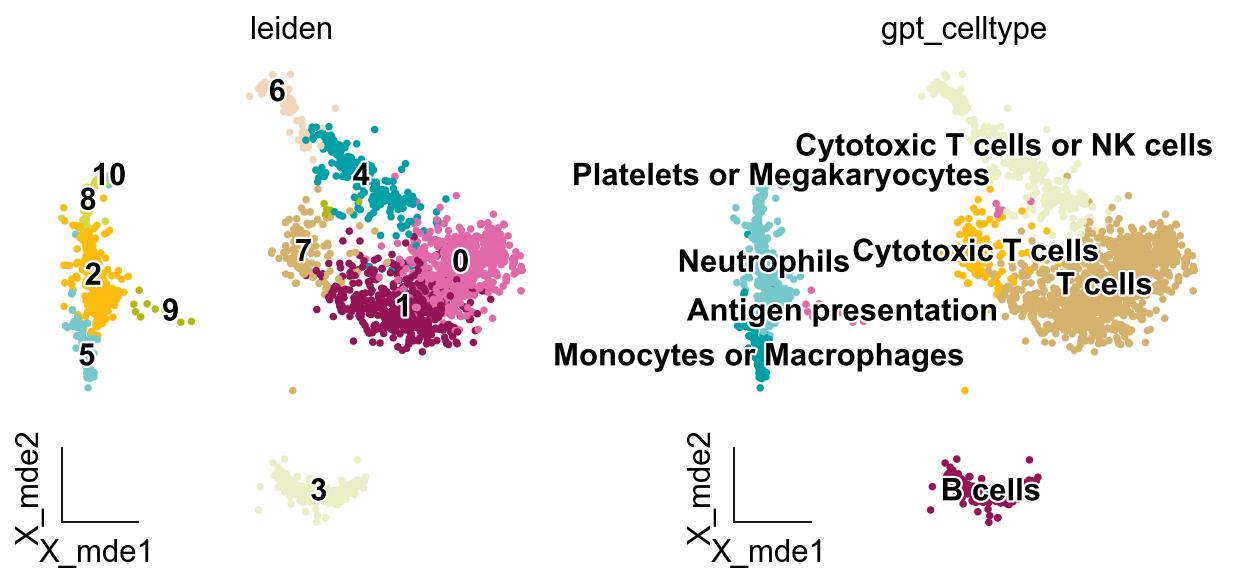

In [20]:
ov.pl.embedding(adata,
                   basis='X_mde',
                   color=['leiden','gpt_celltype'], 
                   legend_loc='on data', 
                   frameon='small',
                   legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

## More model

Our implementation of `gptcelltype` in `omicverse` supports almost all large models that support the `openai` api format.

In [27]:
all_markers={'cluster1':['CD3D','CD3E'],
            'cluster2':['MS4A1']}

### Openai

The OpenAI API uses API keys for authentication. You can create API keys at a user or service account level. Service accounts are tied to a "bot" individual and should be used to provision access for production systems. Each API key can be scoped to one of the following,

- [User keys](https://platform.openai.com/account/api-keys) - Our legacy keys. Provides access to all organizations and all projects that user has been added to; access API Keys to view your available keys. We highly advise transitioning to project keys for best security practices, although access via this method is currently still supported.

- Please select the model you need to use: [list of supported models](https://platform.openai.com/docs/models).


In [28]:
os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='gpt-4o', provider='openai',
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'cluster1': '1. T cell', 'cluster2': '2. B cell'}

### Qwen(通义千问)

- Enabled DashScope service and obtained API-KEY: [Enabled DashScope and created API-KEY](https://help.aliyun.com/zh/dashscope/developer-reference/activate-dashscope-and-create-an-api-key).

- We recommend you to configure API-KEY in environment variable to reduce the risk of API-KEY leakage, please refer to Configuring API-KEY through Environment Variable for the configuration method, you can also configure API-KEY in code, but the risk of leakage will be increased.

- Please select the model you need to use: [list of supported models](https://help.aliyun.com/zh/dashscope/developer-reference/compatibility-of-openai-with-dashscope/?spm=a2c4g.11186623.0.i6#eadfc13038jd5).

**简体中文**

- 已开通灵积模型服务并获得API-KEY：[开通DashScope并创建API-KEY](https://help.aliyun.com/zh/dashscope/developer-reference/activate-dashscope-and-create-an-api-key)。

- 我们推荐您将API-KEY配置到环境变量中以降低API-KEY的泄漏风险，配置方法可参考通过环境变量配置API-KEY。您也可以在代码中配置API-KEY，但是泄漏风险会提高。

- 请选择您需要使用的模型：[支持的模型列表](https://help.aliyun.com/zh/dashscope/developer-reference/compatibility-of-openai-with-dashscope/?spm=a2c4g.11186623.0.i6#eadfc13038jd5)。


In [26]:
os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='qwen-plus', provider='qwen',
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'cluster1': 'CD3D, CD3E: T cells', 'cluster2': 'MS4A1: B cells'}

### Kimi(月之暗面)

- You will need a Dark Side of the Moon API key to use our service. You can create an API key in [Console](https://platform.moonshot.cn/console).

- Please select the model you need to use: [List of supported models](https://platform.moonshot.cn/docs/pricing#%E4%BA%A7%E5%93%81%E5%AE%9A%E4%BB%B7)

**简体中文**

- 你需要一个 月之暗面的 API 密钥来使用我们的服务。你可以在[控制台](https://platform.moonshot.cn/console)中创建一个 API 密钥。

- 请选择您需要使用的模型：[支持的模型列表](https://platform.moonshot.cn/docs/pricing#%E4%BA%A7%E5%93%81%E5%AE%9A%E4%BB%B7)

In [28]:
os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='moonshot-v1-8k', provider='kimi',
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'cluster1': '1. T cell', 'cluster2': '2. B cell'}

### Other Model

You can manually set the `base_url` parameter to specify other models that need to be used, note that the model needs to support Openai's parameters. Three examples are provided here (when you specify the `base_url` parameter, the `provider` parameter will be invalid):

```python
if provider == 'openai':
    base_url = "https://api.openai.com/v1/"
elif provider == 'kimi':
    base_url = "https://api.moonshot.cn/v1"
elif provider == 'qwen':
    base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1"
```

In [30]:
os.environ['AGI_API_KEY'] = 'sk-**'  # Replace with your actual API key
result = ov.single.gptcelltype(all_markers, tissuename='PBMC', speciename='human',
                      model='moonshot-v1-8k', base_url="https://api.moonshot.cn/v1",
                      topgenenumber=5)
result

Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.


{'cluster1': '1. T cell', 'cluster2': '2. B cell'}